In [1]:
# import library
import pandas as pd
import numpy as np
import warnings
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

### Load data

In [2]:
_zipfile_train = zipfile.ZipFile('../local/train.tsv.zip')
_zipfile_test = zipfile.ZipFile('../local/test.tsv.zip')

In [3]:
with _zipfile_train.open('train.tsv') as f:
    df_train = pd.read_csv(f,delimiter='\t')
with _zipfile_test.open('test.tsv') as f:
    df_test = pd.read_csv(f,delimiter='\t')

### EDA

In [4]:
df_train.columns, df_test.columns

(Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object'),
 Index(['PhraseId', 'SentenceId', 'Phrase'], dtype='object'))

In [5]:
# drop unnecessary columns
df_train.drop(columns=['PhraseId', 'SentenceId'], inplace=True)
df_train.shape

(156060, 2)

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

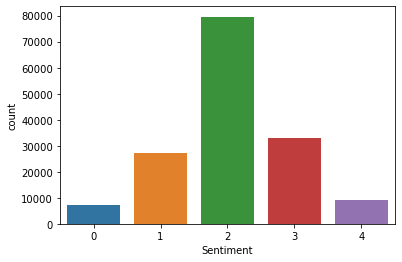

In [6]:
sns.countplot(df_train['Sentiment'])

### Word preprocessing

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
tokenizer = Tokenizer(num_words = 20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['Phrase'])
word_index = tokenizer.word_index
word_sequences = tokenizer.texts_to_sequences(df_train['Phrase'])
x_train = tokenizer.texts_to_sequences(df_test['Phrase'])
print('Number of unique word: {}'.format(len(word_index)-1))

Number of unique word: 15288


In [9]:
# specify the length of sentence within 50 words
# keep zero at the end of sentence if not 50 words
# truncate the end of words if longer than 50
padded = pad_sequences(word_sequences, maxlen=50, padding='post', truncating='post')
x_train= pad_sequences(x_train, maxlen=50, padding='post', truncating='post')

In [10]:
y = np.array(pd.get_dummies(df_train['Sentiment']))

### Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPool1D

In [12]:
model = Sequential(name='base_model')
model.add(Embedding(input_dim = len(word_index) + 1, 
                    output_dim = 16,
                    input_length = 50,
                    mask_zero = True))
model.add(Dropout(.2))
# numpy version has to download to 1.19.5 
# this is the dependency package for tensorflow
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation = 'softmax'))

In [13]:
word_dict = {k:i for i,k in word_index.items()}
word_dict.get(15290)

In [14]:
model.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            244640    
_________________________________________________________________
dropout (Dropout)            (None, 50, 16)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           148480    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
             metrics = ['acc'])

In [16]:
# stop the trainng if validation loss is not improved for 5 rounds
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [17]:
%%time
history = model.fit(x = padded, y = y,
                   batch_size = 512,
                   epochs = 15, 
                   validation_split=.2,
                   callbacks=[callback],
                   verbose=1)

Epoch 1/15
244/244 [==============================] - 126s 517ms/step - loss: 1.1854 - acc: 0.5380 - val_loss: 1.1210 - val_acc: 0.5401
Epoch 2/15
244/244 [==============================] - 126s 517ms/step - loss: 0.9579 - acc: 0.6129 - val_loss: 1.0016 - val_acc: 0.5911
Epoch 3/15
244/244 [==============================] - 126s 518ms/step - loss: 0.8053 - acc: 0.6713 - val_loss: 0.9813 - val_acc: 0.5975
Epoch 4/15
244/244 [==============================] - 126s 518ms/step - loss: 0.7517 - acc: 0.6890 - val_loss: 0.9925 - val_acc: 0.5991
Epoch 5/15
244/244 [==============================] - 127s 521ms/step - loss: 0.7216 - acc: 0.6994 - val_loss: 0.9954 - val_acc: 0.5991
Epoch 6/15
244/244 [==============================] - 129s 530ms/step - loss: 0.6970 - acc: 0.7083 - val_loss: 1.0054 - val_acc: 0.5954
Epoch 7/15
244/244 [==============================] - 127s 522ms/step - loss: 0.6765 - acc: 0.7154 - val_loss: 1.0189 - val_acc: 0.5985
Epoch 8/15
244/244 [============================

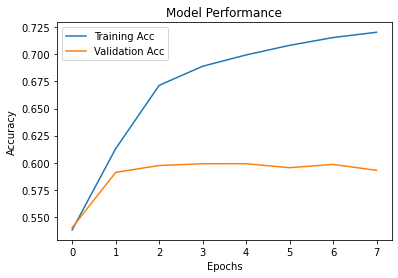

In [18]:
hist = pd.DataFrame(history.history)
hist['epochs'] = history.epoch

plt.figure()
plt.plot(hist['epochs'], hist['acc'], label='Training Acc')
plt.plot(hist['epochs'], hist['val_acc'], label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()

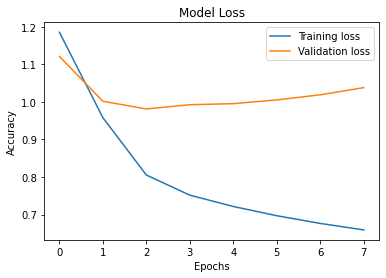

In [19]:
plt.figure()
plt.plot(hist['epochs'], hist['loss'], label='Training loss')
plt.plot(hist['epochs'], hist['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Loss')
plt.legend()
plt.show()

In [20]:
# store trained model
filename = 'firstSubmission.h5'
model.save(filename)

In [22]:
%%time
# create submission
df_test['y_pred'] = np.argmax(model.predict(x_train), axis=1)
submission = df_test[['PhraseId', 'y_pred']].rename(columns={'y_pred': 'Sentiment'})
submission.to_csv('firstSubmission.csv', index=False, header=True)

Wall time: 24.8 s
